### 注意力机制
![](img/2022-05-18-11-03-37.png)

### 注意力的可视化
平均汇聚层可以视为输入的加权平均,各个输入的权重是相同的.实际上,注意力汇聚得到的是加权平均的总和,权重是给定的query和不同的key之间计算得出的.

In [5]:
import torch
import sys,os
sys.path.append(os.path.abspath("../"))
import lmy
import d2l
def show_heatmaps(matrices,xlabel,ylabel,titiles=None,figsize=(2.5,2.5),cmap='Reds'):
    """显示矩阵热图"""
    """在后面的章节中,我们将经常调用show_heatmaps函数来显示注意力权重。"""
    d2l.use_svg_display()
    num_rows,num_cols = matrices.shape[0],matrices.shape[1]
    fig,axes = d2l.plt.subplots(num_rows,num_cols,figsize=figsize,
                                sharex=True,sharey=True,squeeze=False)
    for i,(row_axes,row_matrices) in enumerate(zip(axes,matrices)):
        for j,(ax,matrix) in enumerate(zip(row_axes,row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(),cmap=cmap)
            if i == num_rows -1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titiles:
                ax.set_title(titiles[j])
    fig.colorbar(pcm,ax=axes,shrink=.6)

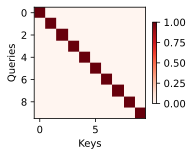

In [6]:
attention_weights = torch.eye(10).reshape((1,1,10,10))
show_heatmaps(attention_weights,xlabel='Keys',ylabel='Queries')

### 注意力汇聚(Attention Pooling):Nadaraya-Watson核回归
注意力汇聚有选择地聚合了值(感官输入)以生成最终的输出.
本节介绍64年提出的Nadaraya-Watson核回归模型

#### 生成数据集
考虑回归问题:给定成对的"输入-输出"数据集{(x1,y1),....{xn,yn}},如何学习f来预测任意新输入x的输出$\hat{y} = f(x)$

根据下面的非线性函数生成一个人工数据集 并加入噪声$\epsilon$(服从0,.5的正态分布)
$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

In [30]:
num_train = 50
x_train, indices = torch.sort(torch.rand(num_train)*5)

def f(x):
    return 2*torch.sin(x)+x**.8

ep = torch.normal(0,.5,(num_train,))
y_train = f(x_train)+ep

x_test = torch.arange(0,5,.1) 
y_label = f(x_test)
num_test = len(x_test)

In [34]:
def plot_kernel_reg(y_hat):
    # 将真实的标签和预测的标签画在一起
    d2l.plot(x_test, [y_label, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, '.', alpha=0.5)

### 使用平均汇聚层

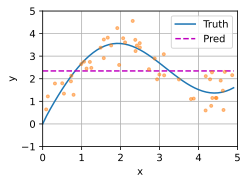

In [35]:
y_hat = torch.repeat_interleave(y_train.mean(),num_test)

plot_kernel_reg(y_hat)
# y_hat

### 非参数的注意力汇聚

明显,平均池化不受自变量x的影响, Nadaraya和Watson提出了更好的想法,根据输入位置对输出$y_i$进行加权.公式如下
$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$
其中K是核Kernel,公式所描述的估计器被称为Nadaraya-Watson kernel regression
这里不讨论K的细节,看得出来 K反应了当前的权重, 通过注意力机制框架的角度对公式进行重写,获得通用注意力汇聚(Attention Pooling)公式:
$$
f(x)= \sum_{i=1}^n \alpha(x,x_i)y_i
$$
其中x是查询,(xi,yi)是键值对. 这里将查询x和键xi之间的关系建模为 注意力权重$\alpha(x,x_i)$,这个权重将分配各每一个对应值yi.

**高斯核函数Gaussian Kernel**
$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2})
$$
将高斯核代入可得
$$
\begin{split}
\begin{aligned} 
f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i
\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{(x - x_i)^2}{2}\right)}{\sum_{j=1}^n \exp\left(-\frac{(x - x_j)^2}{2}\right)}y_i 
\\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{(x - x_i)^2}{2}\right) y_i. 
\end{aligned}
\end{split}
$$

公式中当一个查询x越接近于键xi,其权值越大,即"获取了更多的注意力"
值得注意的是,NW核回归是一个非参数模型.因此上述狮子是非参数的(无需学习的)注意力汇聚模型

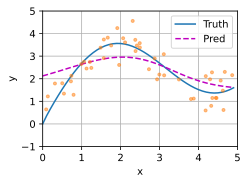

In [36]:
X_repeat = x_test.repeat_interleave(num_train).reshape((-1,num_train))
X_repeat
attention_weights = torch.nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
y_hat = torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)

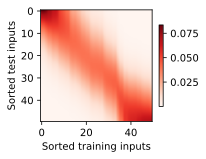

In [40]:
x=attention_weights.unsqueeze(0).unsqueeze(0)
show_heatmaps(x,xlabel='Sorted training inputs',
              ylabel='Sorted test inputs')
# 这里测试数据相当于query,而训练数据相当于key,两个输出通过排序后,因此可知"q-k"对越来越接近,注意力汇聚的权重就越高

### 带参数的注意力汇聚
非参数的NW核回归具有一致性(consistency)的优点:如果有足量的数据,此模型会收敛到最优.尽管如此,我们还是可以轻松地将参数集成到注意力汇聚中.\
**将距离乘以一个科学系的参数$w$**
$$
f(x) = \sum_{i=1}^n \mathrm{softmax}\left(-\frac{\left((x-x_i)w\right)^2}{2}\right)y_i
$$


#### 批量矩阵乘法
为了更有效地计算小批量数据的注意力,我们可以利用深度学习开发框架中提供的批量矩阵乘法.
假设第一个小批量数据包含n个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$,形状为a*b,

第二个小批量包含n个矩阵$\mathbf{Y}_1,\ldots,\mathbf{Y}_n$,形状为b*c,

矩阵的批量乘法得到n个矩阵$\mathbf{X}_1{Y}_1,\ldots, \mathbf{X}_n{Y}_n$,形状为a*c.
因此假定两个张量的形状分别为(n,a,b)和(n,b,c) 得到批量矩阵乘法输出为(n,a,c)

In [42]:
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])